<a href="https://colab.research.google.com/github/EmperorNao/MLHub/blob/main/examples/ipynb/TitanicForTMV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -O titanic.csv https://vk.com/doc209646771_630260948?hash=eb14543121e9b21185&dl=470a8e77f481e8408f 

--2022-02-13 15:26:02--  https://vk.com/doc209646771_630260948?hash=eb14543121e9b21185
Resolving vk.com (vk.com)... 87.240.190.72, 87.240.190.78, 93.186.225.208, ...
Connecting to vk.com (vk.com)|87.240.190.72|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://psv4.userapi.com/c534536/u209646771/docs/d44/71b4a72219bb/train.csv?extra=5slN_Cjz-CHJehgpjnCg4LMvhk0YndPrmAKySCSP_Ar4S61f33bZy5fheCjKioLCuw64LGDrcNI5xtOaea-CVWdNRWpQTTjTxIPbpTawR3Nh5PynjokVFTBGzJvgWdt5C_7XAeQWz-IN&dl=1 [following]
--2022-02-13 15:26:02--  https://psv4.userapi.com/c534536/u209646771/docs/d44/71b4a72219bb/train.csv?extra=5slN_Cjz-CHJehgpjnCg4LMvhk0YndPrmAKySCSP_Ar4S61f33bZy5fheCjKioLCuw64LGDrcNI5xtOaea-CVWdNRWpQTTjTxIPbpTawR3Nh5PynjokVFTBGzJvgWdt5C_7XAeQWz-IN&dl=1
Resolving psv4.userapi.com (psv4.userapi.com)... 87.240.190.89, 87.240.137.134, 87.240.137.140, ...
Connecting to psv4.userapi.com (psv4.userapi.com)|87.240.190.89|:443... connected.
HTTP request sent, awaiting respons

In [85]:
!pip install numpy==1.21.5

     |████████████████████████████████| 15.7 MB 277 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
from math import ceil
from sklearn import linear_model
import matplotlib.pyplot as plt

In [3]:
class DimensionsException(Exception):

    def __init__(self, s):
        self.msg = s
        super().__init__()

    def __str__(self):
        return self.msg

In [4]:

def one_hot_encoding(x: pd.DataFrame) -> np.ndarray:

    unique = x.unique()

    ohe = np.zeros([len(x), len(unique)])
    for i, kv in enumerate(x.iteritems()):
        index, v = kv
        ohe[i][np.where(unique == v)] = 1

    return ohe


def scale(x: np.ndarray) -> np.ndarray:

    z = ((x - x.mean()) / x.std())
    return z


def titanic(df):

    #df = df.dropna()
    df = df.apply(lambda x: x.fillna(x.value_counts().index[0]))
    numerical = ['Age', 'Fare', ]
    categorical = ['Pclass', 'Sex']
    target = ['Survived']

    #df.columns = columns
    un = df[target].iloc[:, 0].unique()
    y = (df[target] == un[0]).to_numpy(dtype="int")
    x = []

    processed = []
    # one-hot-encoding categorical
    for col in categorical:
        x.append(one_hot_encoding(df[col]))

    x += [np.expand_dims(df[col].to_numpy(), -1) for col in numerical]
    for col in numerical:
        x.append(np.expand_dims(scale(df[col].to_numpy()), -1))

    for ohe in processed:
        x.append(scale(ohe))

    return np.hstack(x), y


def get_dataset(name) -> (np.ndarray, np.ndarray):

    if name == "titanic":

        df = pd.read_csv(r"titanic.csv")
        return titanic(df)


def train_test_split(x: np.ndarray,
                     y: np.ndarray,
                     ratio: float = 0) -> ((np.ndarray, np.ndarray), (np.ndarray, np.ndarray)):

    if x.shape[0] != y.shape[0]:
        raise DimensionsException("X and y has different number of objects")

    if 1 < ratio < 0:
        raise ValueError(f"Ratio need to be in [0, 1], provided {ratio}")

    idx_full = range(0, x.shape[0])
    size = ceil(x.shape[0] * ratio)
    idx_train = list(np.random.choice(idx_full, size))
    idx_test = list(set(idx_full).difference(idx_train))

    return (x[idx_train, :], x[idx_test, :]), (y[idx_train], y[idx_test])


In [10]:
import numpy as np


def sgd(x: np.ndarray,
        y: np.ndarray,
        loss_fn, grad_loss_fn,
        lr = 1e-4,
        smart_init=False,
        w: np.ndarray = None,
        lam: float = 0.9,
        eps=1e-6,
        batch_size=1,
        max_iter=10000,
        logging=False) -> (np.ndarray, float):

    n_features = x.shape[1]
    n_objects = x.shape[0]

    if w is None:
        if not smart_init:
            w = np.zeros(n_features)
            for i in range(n_features):
                w[i] = np.random.normal(0, 1 / (2 * x.shape[0]))

        w = np.expand_dims(w, -1)

    # loss = loss_fn(w, x, y)
    loss = float('inf')

    history = []
    iter = 0

    if logging:
        print(f"Iter = {iter}, Loss = {loss}")

    while abs(loss) > eps and iter < max_iter:# or abs(np.sum(delta_w)) > (eps * n_features)):

        idx_obj = np.random.choice(range(n_objects), size=batch_size)
        x_obj = x[idx_obj,:]
        y_obj = y[idx_obj]

        grad = grad_loss_fn(w, x_obj, y_obj)

        delta_w = lr * grad
        w = w - delta_w

        loss = np.mean(loss_fn(w, x_obj, y_obj))

        #print(f"iter {iter}\ngrad = {grad}\ndelta w = {delta_w}\ndelta q = {delta_q}\n\n")
        iter += 1
        history.append(loss)

        if logging:
            print(f"Iter = {iter}, Loss = {loss}, delta_w = {delta_w}")

    return w, loss, history


class SGDOptimizer:

    def __init__(self,
                 lr: float =1e-4,
                 smart_init=False,
                 lam: float = 0.9,
                 eps = 1e-6,
                 max_iter = 10000,
                 logging=False,
                 batch_size=1):

        self.lr = lr
        self.smart_init = smart_init
        self.lam = lam
        self.eps = eps
        self.max_iter = max_iter
        self.logging = logging
        self.bs = batch_size

    def fit(self,
            x: np.ndarray,
            y: np.ndarray,
            loss_fn,
            grad_loss_fn,
            w: np.ndarray = None,
            get_hist=False) -> (np.ndarray, float):
        # weight and quality

        res = sgd(x, y, loss_fn, grad_loss_fn,
                   self.lr, self.smart_init, w, self.lam, self.eps, self.bs, self.max_iter, self.logging)

        if get_hist:
            return res

        else:
            return res[0], res[1]

In [6]:
def accuracy(y_real: np.ndarray, y_pred: np.ndarray) -> float:

    return np.mean(y_real == y_pred)


def precision(y_real: np.ndarray, y_pred: np.ndarray) -> float:

    pos_idx = np.argwhere(y_real == 1)
    return np.sum(y_real[pos_idx] == y_pred[pos_idx]) / (np.sum(y_real[pos_idx] == y_pred[pos_idx]) + np.sum(y_real[pos_idx] != y_pred[pos_idx]))


def recall(y_real: np.ndarray, y_pred: np.ndarray) -> float:

    pos_neg = np.argwhere(y_real == 0)
    return np.sum(y_real[pos_neg] == y_pred[pos_neg]) / (np.sum(y_real[pos_neg] == y_pred[pos_neg]) + np.sum(y_real[pos_neg] != y_pred[pos_neg]))

In [7]:
class LogisticRegression:

    def __init__(self, weights: np.ndarray = None, L2_coefficient: float = 0, logging=False):

        self.weights = weights
        self.L2_coefficient = L2_coefficient if L2_coefficient != 0 else 0.05
        self.logging=logging

    def fit(self, x: np.ndarray, y: np.ndarray, optimizer):

        if x.shape[0] != y.shape[0]:
            raise DimensionsException("X and y has different number of objects")

        n_objects = x.shape[0]
        n_features = x.shape[1] + 1
        self.classes = np.unique(y)

        n_classes = self.classes.shape[0]

        ones = 1 * np.ones((n_objects, 1))

        self.weights = np.random.normal(scale=1/(2 * np.pi * x.shape[0]), size=(n_features, n_classes))

        x_padded = np.hstack([x, ones])

        y_transformed = []
        for el_y in y:
            z = np.zeros(n_classes)
            z[np.where(self.classes == el_y)] = 1
            y_transformed.append(z)

        w, q, history = optimizer.fit(x_padded, np.array(y_transformed), self.loss, self.grad_loss, w=self.weights, get_hist=True)

        self.weights = w
        return history

    def softmax(self, v):
        # v = m * k
        # outp = m * k
        exp = np.exp(v - np.max(v))
        denom = np.expand_dims(np.sum(exp, axis=1), -1)
        ret = exp / denom
        return ret

    def softmax_grad(self, v):
        # v = m x k
        # outp = m x k x k

        sm = self.softmax(v)
        m = v.shape[0]
        c = v.shape[1]
        return np.array(np.array([np.array([sm[k][i] * (1 - sm[i]) if i == j else -1 * sm[k][i] * sm[k][j] for i in range(c)]) for j in range(c)]) for k in range(m))

    def loss(self, w: np.ndarray, x: np.ndarray, y: np.ndarray):
        # x.shape = m x n
        # y.shape = m x k
        # w.shape = k x n
        # outp = k x 1

        # sm(k x n * n x m = k x m)

        sm = self.softmax(np.dot(x, w))
        l = -1 * np.mean(np.sum(y * np.log(sm + 1e-6 * np.ones_like(sm)), axis=1), axis=0)
        return l

    def grad_loss(self, w: np.ndarray, x: np.ndarray, y: np.ndarray):
        # x.shape = m x n
        # y.shape = m x k
        # w.shape = k x n
        # outp =

        # sm(k x n * n x m = k x m)
        sm = self.softmax(np.dot(x, w))
        prod = sm * y
        diff = prod - y
        return np.dot(x.T, diff)

    def predict(self, x: np.ndarray) -> np.ndarray:

        n_objects = x.shape[0]
        n_features = x.shape[1] + 1
        ones = 1 * np.ones((n_objects, 1))

        x_padded = np.hstack([x, ones])

        prob = self.softmax(self.softmax(np.dot(x_padded, self.weights)))
        pred = np.argmax(prob, axis=1)
        if self.logging:
            print(prob)
            print(pred)

        return pred

In [31]:

def titanic_example():

    np.random.seed(30)
    x, y = get_dataset("titanic")

    optim = SGDOptimizer(lr=1e-4, max_iter=10000, lam=0.85, batch_size=1)
    simple = LogisticRegression()
    sklearn = linear_model.LogisticRegression(max_iter=100)

    x_pair, y_pair = train_test_split(x, y, ratio=0.75)

    x_train, x_test = x_pair
    y_train, y_test = y_pair

    y_test = np.squeeze(y_test, -1)

    history = simple.fit(x_train, y_train, optim)
    sklearn.fit(x_train, np.squeeze(y_train, -1))

    y_pred_simple = simple.predict(x_test)
    y_pred_sklearn = sklearn.predict(x_test)

    print(f"ACC on SLKEARN = {accuracy(y_test, y_pred_sklearn)}")
    print(f"ACC on our LR = {accuracy(y_test, y_pred_simple)}")

    print(f"precision on SLKEARN = {precision(y_test, y_pred_sklearn)}")
    print(f"precision on our LR = {precision(y_test, y_pred_simple)}")

    print(f"recall on SLKEARN = {recall(y_test, y_pred_sklearn)}")
    print(f"recall on our LR = {recall(y_test, y_pred_simple)}")

    pos_index = np.where(y_test == 1)
    neg_index = np.where(y_test == 0)
    print(f"SKLEARN:\n"
          f"TP = {np.sum(y_test[pos_index] == y_pred_sklearn[pos_index])}\n"
          f"FP = {np.sum(y_test[pos_index] != y_pred_sklearn[pos_index])}\n"
          f"FN = {np.sum(y_test[neg_index] != y_pred_sklearn[neg_index])}\n"
          f"TN = {np.sum(y_test[neg_index] == y_pred_sklearn[neg_index])}")

    print(f"LR:\n"
          f"TP = {np.sum(y_test[pos_index] == y_pred_simple[pos_index])}\n"
          f"FP = {np.sum(y_test[pos_index] != y_pred_simple[pos_index])}\n"
          f"FN = {np.sum(y_test[neg_index] != y_pred_simple[neg_index])}\n"
          f"TN = {np.sum(y_test[neg_index] == y_pred_simple[neg_index])}")

    fig = plt.figure(figsize=(15, 10))

    plt.title("Loss")
    plt.plot([i for i in range(len(history))], history)
    plt.show()

jupyter ломается из-за zero division, если ставить batch_size != 1


Но локально отлично учится при batch_size = 128, догоняет стандартный sklearn

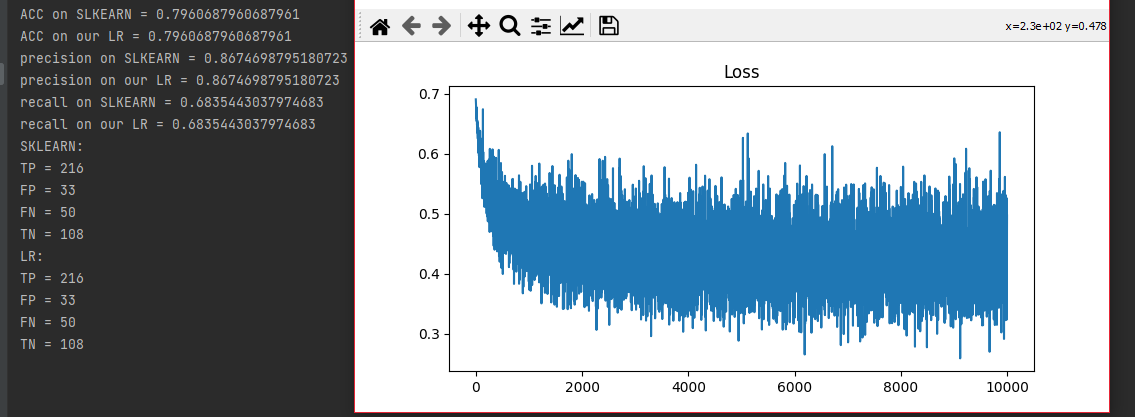



ACC on SLKEARN = 0.7637614678899083
ACC on our LR = 0.676605504587156
precision on SLKEARN = 0.8174603174603174
precision on our LR = 0.7579365079365079
recall on SLKEARN = 0.6902173913043478
recall on our LR = 0.5652173913043478
SKLEARN:
TP = 206
FP = 46
FN = 57
TN = 127
LR:
TP = 191
FP = 61
FN = 80
TN = 104


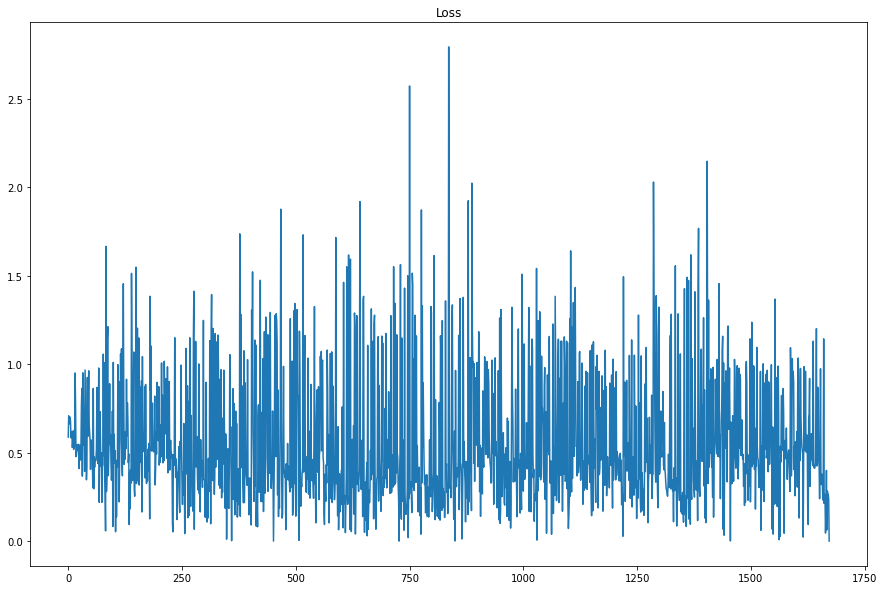

In [32]:
titanic_example()